In [1]:
'''
NON linear BVP:
     - div( mu(u) * grad(u) ) + w * grad(u) = f  in domain
                                           u = g  on bdry dirichlet
                         - mu(u) nabla(u).n = 0 on bdry Neumann
    with w: given velocity field; mu: given diffusivity coeff. 
    
Example of basic exact solution in domain=(0,1)^2: 
        u = 'sin(x[0]) + sin(x[1])' corresponds to: 
        f = 'cos(x[0]) + cos(x[1]) + sin(x[0]) + sin(x[1])' and g = 'sin(x[0]) + sin(x[1])'
'''


from dolfin import *
import sys
# from fenics import *
from sys import exit
import numpy as np 
import matplotlib.pyplot as plt

In [34]:
# import warnings
# warnings.filterwarnings('ignore')

#
# FUNCTIONS
#

# transform a npy array to a FEniCS field
def numpy_to_fenics(array, function_space):
	function = Function(function_space)
	for i in range(len(function.vector()[:])):
		function.vector()[i] = array[i]
	return function
#
# Dirichlet boundary conditions
#
# The functions below return True for points inside the subdomain and False for the points outside.
# Because of rounding-off errors, we specify |𝑥−1|<𝜖, where 𝜖 is a small number (such as machine precision).
tol_bc = 1e-7
def u_bdry_x0(x, on_boundary): # Left bdry
 return bool(on_boundary and (near(x[0], 0, tol_bc)))
def u_bdry_x1(x, on_boundary): # Right bdry
 return bool(on_boundary and (near(x[0], 1., tol_bc)))

#
# The non linear parameter m(u) and its derivative
#
m = 0 # power-law index
#print('The power-law exponent of the non linearity m = ', m)
print('The expression of mu(u) is ... see function !')
def mu(u):
	if m == 0:
		return (1. + 1.e-30*u)
	return (0.1+u)**int(m) # non linear law
	#return 1.

def dmu_du(u):
	if m == 0:
		return 1.e-30
	return m * (0.1+u)**int(m-1)
	#return u * 0.

The expression of mu(u) is ... see function !


In [35]:

###############################
#os.system("clear") 
print('#')
print('# MAIN PROGRAM')
print('#')

# Create mesh and function space
NP =  30; print('Number of mesh points NP = ', NP)
mesh = UnitSquareMesh(NP,NP)
k = 2 ; print('Order of the Lagrange FE k = ', k)
V = FunctionSpace(mesh, "CG", int(k)) # Lagrange FE, order k


#
# MAIN PROGRAM
#
Number of mesh points NP =  30
Order of the Lagrange FE k =  2


    Object cannot be plotted directly, projecting to piecewise linears.


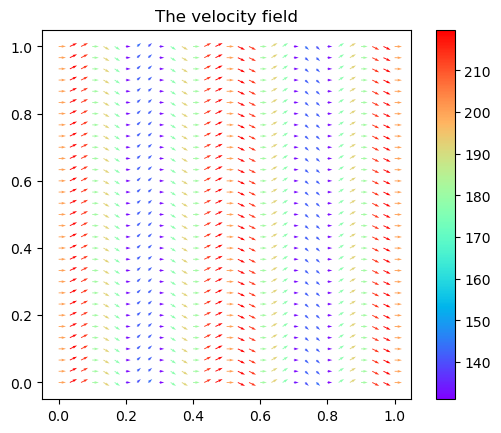

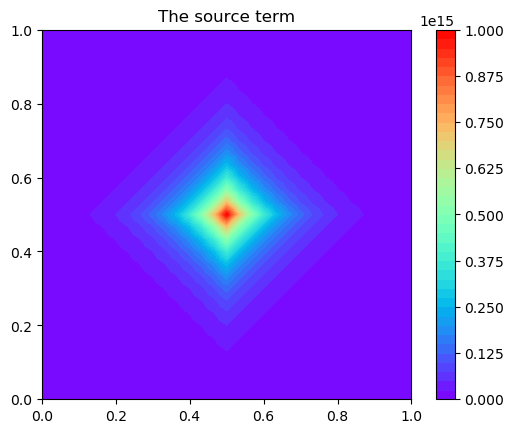

In [36]:
advection = True
if advection:
        # Define velocity field
        # Be creative ! Define your own velocity field following the instructions
        vel_amp = 1.e+2#; print('vel_amp =',vel_amp)
        vel_exp = Expression(('(1.+abs(cos(2*pi*x[0])))', 'sin(2*pi/0.2*x[0])'), element = V.ufl_element())
        #vel_exp = Expression(('(1.+abs(cos(2*pi*x[0])))', 'sin(2*pi/0.2*x[0])'), element = V.ufl_element())
        #vel_exp = Expression(('0.', '0.'), element = V.ufl_element())
        V_vec = VectorFunctionSpace(mesh,"CG", k)
        vel = vel_amp * interpolate(vel_exp,V_vec)
        # plot
        p=plot(vel,title='The velocity field')
        p.set_cmap("rainbow"); plt.colorbar(p);
        plt.show()


# To transform a vector vec to a fenics object vf
#vf= Function(V); vf.vector().set_local(vec)

# The physical RHS 
#f_exp = Expression('1.', element = V.ufl_element())
fp_exp = Expression('1e+15 * exp( -( abs(x[0]-0.5) + abs(x[1]-0.5) ) / 0.1 )', element = V.ufl_element())
fp = interpolate(fp_exp,V)
#fp = Expression('0.', degree=u.ufl_element().degree())
plt.figure()
p2=plot(fp,title='The source term')
p2.set_cmap("rainbow"); plt.colorbar(p2)
plt.show() #(block=True)


##################################################################
#
# Newton - Raphson algorithm: Home-implemented non linear solver :)
#
##################################################################
#
# Initialization: u0 solution of a semi-linearized BVP
#
Calling FFC just-in-time (JIT) compiler, this may take some time.
    Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Peclet number Pe: approx. (min., max.) values for u0 :  64.78 109.58
Num. Peclet number Pe_h=(h.Pe): approx. (min., max.) values for u0 :  3.05 5.17
   press any key to resume...


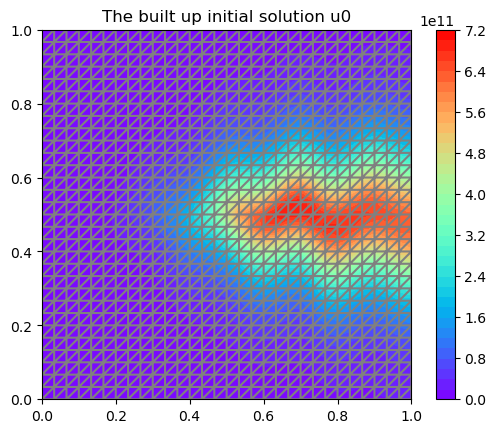

In [37]:


print('##################################################################')
print('#')
print('# Newton - Raphson algorithm: Home-implemented non linear solver :)')
print('#')
print('##################################################################')

print('#')
print('# Initialization: u0 solution of a semi-linearized BVP')
print('#')

# Trial & Test functions
u = TrialFunction(V); v = TestFunction(V)

#
# Boundary conditions
# Dirichlet b.c.
u_diri_non_homog = Expression('293.', degree=u.ufl_element().degree())
u_diri_homog = Expression('0.', degree=u.ufl_element().degree())             
bc = DirichletBC(V, u_diri_non_homog, u_bdry_x0)

# Diffusivity coeff. depending on the field u0
u0_mu_exp = u_diri_non_homog
mu0 = mu( interpolate(u0_mu_exp,V) )

# A semi-linearized pb
if advection:
        F0 = dot(mu0 * grad(u),grad(v)) * dx + dot(vel, grad(u)) * v * dx - fp * v * dx
        # Add the SUPG stabilisation terms
        vnorm = sqrt( dot(vel, vel) )
        h = MaxCellEdgeLength(mesh)
        delta = h / (2.0*vnorm)
        residual = - div(mu0 * grad(u) ) + dot(vel, grad(u)) - fp  # the residual expression
        F0 += delta * residual * dot(vel, grad(v)) * dx # the enriched weak formulation
else:
        F0 = dot(mu0 * grad(u),grad(v)) * dx - fp * v * dx
# The bilinear and linear forms
a0 = lhs(F0); L0 = rhs(F0)

# Neumann bc
# Nothing to do since they are here homogeneous !
# F0 += int-de-bord

# Solve the linear system
u0 = Function(V)
solve(a0 == L0, u0, bc)# , [bc0,bc1])

if advection:
        # Peclet number(s)
        Pe = 0.5 * sqrt(dot(vel, vel))/ mu0
        Pe_np = project(Pe,V).vector().get_local()
        hmax=mesh.hmax(); #print(type(hmax))
        Peh_np = hmax * Pe_np
        print('Peclet number Pe: approx. (min., max.) values for u0 : ', '{0:.2f}'.format(Pe_np.min()), '{0:.2f}'.format(Pe_np.max()))
        print('Num. Peclet number Pe_h=(h.Pe): approx. (min., max.) values for u0 : ', '{0:.2f}'.format(Peh_np.min()), '{0:.2f}'.format(Peh_np.max()))
        ans = print("   press any key to resume...")

# Plot the solution
plt.figure(); plot(mesh)
p=plot(u0, title='The built up initial solution u0')
p.set_cmap("rainbow"); plt.colorbar(p);
plt.show(block=False)


#
# Iterations
#
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
    Solving linear variational problem.
Newton-Raphson iteration # 1 ; error =  0.0027509283945178656
    Solving linear variational problem.
Newton-Raphson iteration # 2 ; error =  1.2941600359909073e-16
* Newton-Raphson algorithm has converged: the expected stationarity has been reached. eps_du =  1e-09


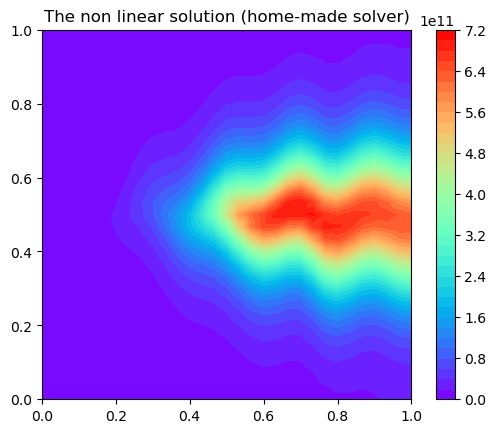

In [38]:

print('#')
print('# Iterations')
print('#') 
i_max = 40 # max of iterations
i = 0; error = 1. # current iteration
eps_du = 1e-9 # tolerance on the relative norm 

# The FE unknowns 
du = TrialFunction(V)
un, dun = Function(V), Function(V)
un = u0 # initialisation

# Loop
while (error>eps_du and i<i_max): 
 i+=1 # update the current iteration number
 #print("Newton-Raphson iteration #",i," begins...")
 
 # mu and dmu_du at the current iteration
 mu_n = mu(un)
 dmu_du_n = dmu_du(un)

 if advection:
        # LHS of the linearized variational formulation
        # if m == 0:
        #         a = inner( mu_n*grad(du) , grad(v) ) * dx + inner(vel, grad(du)) * v * dx
        # else:
        #         a = inner( mu_n*grad(du) , grad(v) ) * dx + inner(vel, grad(du)) * v * dx + inner(dmu_du_n*du *grad(un) , grad(v)) * dx
        a = inner( mu_n*grad(du) , grad(v) ) * dx + inner(vel, grad(du)) * v * dx + inner(dmu_du_n*du *grad(un) , grad(v)) * dx
        # RHS of the linearized eqn
        Lan = inner(mu_n*grad(un) , grad(v)) * dx  + inner(vel, grad(un)) * v * dx 
        L = fp * v * dx - Lan
        
        # Add the SUPG stabilisation terms. The residual expression: residu = residu_lhs - fp
        Zero_exp=Expression('0.', element = V.ufl_element())
        #residual_lhs = -  div( mu_n*grad(du) ) + dot(vel, grad(du))
        #residual_rhs = interpolate(Zero_exp,V)  
        #print('   SUPG: residual expression of the semi-linearized eqn ...')
        residual_lhs = -  div( mu_n*grad(du) ) + dot(vel, grad(du)) - div( dmu_du_n*du * grad(un))
        residual_rhs = -  div( mu_n*grad(un) ) + dot(vel, grad(un))
        # print('   SUPG: complete residual expression of the linearized eqn :)')
 else:
        # LHS of the linearized variational formulation
        # if m == 0:
        #         a = inner( mu_n*grad(du) , grad(v) ) * dx
        # else:
        #         a = inner( mu_n*grad(du) , grad(v) ) * dx + inner(dmu_du_n*du *grad(un) , grad(v)) * dx
        a = inner( mu_n*grad(du) , grad(v) ) * dx + inner(dmu_du_n*du *grad(un) , grad(v)) * dx
        # RHS of the linearized eqn
        Lan = inner(mu_n*grad(un) , grad(v)) * dx 
        L = fp * v * dx - Lan
         
 #a += delta * residual_lhs * dot(vel, grad(v)) * dx
 #L += fp * v * dx + residual_rhs * v * dx 
 # Create bilinear and linear forms
 #a = lhs(F); L = rhs(F)
 
 # Homogeneous Dirichlet b.c. 
 bc0 = DirichletBC(V, u_diri_homog, u_bdry_x0)
 
 # Solve
 solve(a == L, dun, bc0)
 un.assign(un+dun) # update the solution

 # relative diff.
 dun_np = dun.vector().get_local()
 un_np = un.vector().get_local()
 #print(type(dun_np)) #print(dun_np.shape)
 error = np.linalg.norm(dun_np) / np.linalg.norm(un_np)
 print("Newton-Raphson iteration #",i,"; error = ", error)
 # test
 if (i == i_max):
  print("Warning: the algo exits because of the max number of ite ! error = ",error)

if (i < i_max):
  print("* Newton-Raphson algorithm has converged: the expected stationarity has been reached. eps_du = ",eps_du)
#
# Plots
#
plt.figure();# plot(mesh)
p=plot(un, title='The non linear solution (home-made solver)')
p.set_cmap("rainbow"); plt.colorbar(p);
plt.show()


In [ ]:
print('#####################################')
print('# Fenics non linear solver (blackbox)')
print('#####################################')
# A useful webpage:
# http://home.simula.no/~hpl/homepage/fenics-tutorial/release-1.0-nonabla/webm/nonlinear.html

# The non linear variational formulation
u = TrialFunction(V)
u_nl = Function(V)
if advection:
        F_nl = inner(mu(u) * grad(u),grad(v)) * dx + inner(vel, grad(u)) * v * dx - fp * v * dx
else:
        F_nl = inner(mu(u) * grad(u),grad(v)) * dx - fp * v * dx
F_nl  = action(F_nl, u_nl)
print(' * Non linear variational form : done')
# differential of the variational form
if advection:
        dF = inner(mu(u_nl) * grad(u), grad(v)) * dx + inner(dmu_du(u_nl) * u * grad(u_nl), grad(v)) * dx + inner(vel, grad(u)) * v * dx
else:
        dF = inner(mu(u_nl) * grad(u), grad(v)) * dx + inner(dmu_du(u_nl) * u * grad(u_nl), grad(v)) * dx
print(' * Differential form : done')

# Solution (with the non homogeneous Dirichlet bc)
bc = DirichletBC(V, u_diri_non_homog, u_bdry_x0)
pb = NonlinearVariationalProblem(F_nl, u_nl, bc, dF)
solver  = NonlinearVariationalSolver(pb)
# optional ...
prm = solver.parameters
prm['newton_solver']['absolute_tolerance'] = eps_du * 10
prm['newton_solver']['relative_tolerance'] = eps_du # previously defined
prm['newton_solver']['maximum_iterations'] = i_max  # previously defined
prm['newton_solver']['relaxation_parameter'] = 1.0
#if iterative_solver:
#    prm['linear_solver'] = 'gmres'
#    prm['preconditioner'] = 'ilu'
#    prm['krylov_solver']['absolute_tolerance'] = 1E-9
#    prm['krylov_solver']['relative_tolerance'] = 1E-7
#    prm['krylov_solver']['maximum_iterations'] = 1000
#    prm['krylov_solver']['gmres']['restart'] = 40
#    prm['krylov_solver']['preconditioner']['ilu']['fill_level'] = 0
#set_log_level(PROGRESS)
#

#solve(F == 0, u, bc, solver_parameters={"newton_solver":{"relative_tolerance":1e-6}})
solver.solve()

print('###')
print('# Relative diff. between the two non linear solutions')
print('###')
u_nl_np = u_nl.vector().get_local();
diff_rel= np.linalg.norm(u_nl_np-un_np) / np.linalg.norm(un_np)
print(" * Relative difference between the two computations = ", diff_rel)

#
# Plots
#
plot(mesh)
p=plot(u_nl, title='The non linear solution by Fenics black box solver')
p.set_cmap("rainbow"); plt.colorbar(p); plt.show()

#
u_diff_rel = project((u_nl - un)/u_nl,V) 
plot(mesh)
p=plot(u_diff_rel, title='Relative difference between the two computed solutions')
p.set_cmap("rainbow"); plt.colorbar(p); plt.show()

#####################################
# Fenics non linear solver (blackbox)
#####################################
 * Non linear variational form : done
 * Differential form : done
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 1.910e+12 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 6.242e+108 (tol = 1.000e-08) r (rel) = 3.269e+96 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 2.090e+108 (tol = 1.000e-08) r (rel) = 1.095e+96 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 7.001e+107 (tol = 1.000e-08) r (rel) = 3.666e+95 (tol = 1.000e-09)
    Newton iteration 4: r (abs) = 2.344e+107 (tol = 1.000e-08) r (rel) = 1.228e+95 (tol = 1.000e-09)
    Newton iteration 5: r (abs) = 7.852e+106 (tol = 1.000e-08) r (rel) = 4.112e+94 (tol = 1.000e-09)
    Newton iteration 6: r (abs) = 2.630e+106 (tol = 1.000e-08) r (rel) = 1.377e+94 (tol = 1.000e-09)
    Newton iteration 7: r (abs) = 8.806e+105 (tol = 1.000e-08) r (rel) = 

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.2.0.dev0
*** Git changeset:  unknown
*** -------------------------------------------------------------------------
